In [1]:
import pandas as pd
import itertools
import seaborn as sns
sns.set_context('poster')
sns.set(font_scale=1.2, style='white')

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
from application import get_sql_dataset, prepare_dataset, run_model, add_ab_info
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn import metrics

//anaconda/envs/my_insight_env/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Get dataset and prepare it for running through a model

In [3]:
all_features, cdiff_data, outcomes = get_sql_dataset.main()

postgresql://nwespe@localhost/mimic
Retrieved data from SQL, have outcomes of length: 39429
Flag value counts: False    38049
True      1380
Name: cdiff, dtype: int64
Adjusted data values for age, admission time
Removed outliers for height and weight
Log-transformed values for bands, bilirubin, bun, creatinine, glucose, lactate, inr, and wbc
Merged hospital stays within 90 days, now have outcomes: 35268
Flag value counts: False    34016
True      1252
Name: cdiff, dtype: int64
Removed young patients, now have outcomes: 32092
Flag value counts: False    30840
True      1252
Name: cdiff, dtype: int64
Removed admits for cdiff, now have outcomes: 32000
Flag value counts: False    30840
True      1160
Name: cdiff, dtype: int64
Combined features with outcomes, now have data of length: 31331
Flag value counts: 0    30189
1     1142
Name: outcome, dtype: int64


In [39]:
x_train, y_train, test_set = prepare_dataset.main(cdiff_data, only_ab=False, 
                                                  add_ab=True, multioutcome=False)

Selected features and dropped low-feature rows, now have dataset of length: 31319
Flag value counts: 0    30177
1     1142
Name: outcome, dtype: int64
Balanced dataset by undersampling dominant class, now have dataset of length: 2284
Flag value counts: 1    1142
0    1142
Name: outcome, dtype: int64


In [40]:
list(x_train.columns)

['aniongap',
 'albumin',
 'log_bands',
 'bicarbonate',
 'log_bilirubin',
 'log_bun',
 'log_creatinine',
 'chloride',
 'log_glucose',
 'hemoglobin',
 'log_lactate',
 'platelet',
 'potassium',
 'log_inr',
 'sodium',
 'log_wbc',
 'heartrate_mean',
 'sysbp_mean',
 'diasbp_mean',
 'meanbp_mean',
 'resprate_mean',
 'tempc_mean',
 'spo2_mean_3',
 'weight',
 'bmi',
 'age',
 'rescaled_time',
 'Aminoglycoside',
 'Antifungal',
 'Carbapenem',
 'Cephalosporin',
 'Combination',
 'Fluoroquinolone',
 'Glycopeptide',
 'Lincosamide',
 'Macrolide',
 'Metronidazole',
 'None',
 'Other',
 'Penicillin BS',
 'Sulfonamide',
 'gender',
 'am_admit',
 'admission_type_ELECTIVE',
 'admission_type_EMERGENCY',
 'admission_location_EMERGENCY ROOM ADMIT',
 'admission_location_REFERRAL',
 'admission_location_TRANSFER',
 'ethnicity_WHITE',
 'ethnicity_BLACK',
 'insurance_Medicaid',
 'insurance_Medicare',
 'insurance_Private',
 'marital_status_DIVORCED',
 'marital_status_MARRIED',
 'marital_status_SINGLE',
 'marital_statu

In [41]:
x_vals = x_train.drop(['hadm_id'], axis=1)  #, 'expire'
prefix = 'feat_both_1016'
#test_set.to_csv('/Users/nwespe/Desktop/test_set_' + prefix + '.csv')

In [42]:
x_test = test_set.drop(['outcome', 'hadm_id'], axis=1)
y_test = test_set['outcome'].copy().reset_index(drop=True)

<a list of 0 Text xticklabel objects>


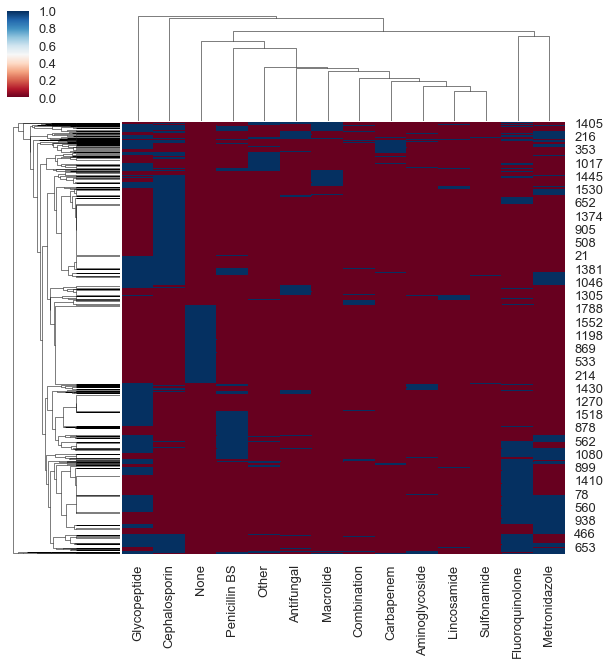

In [74]:
fig = plt.figure(figsize=(24, 24))
g = sns.clustermap(x_vals, cmap='RdBu', xticklabels=1)
locs, labels = plt.xticks()
print labels

# First fit data with logistic regression and random forest

Accuracy: 0.648604269294
Classification report: 
             precision    recall  f1-score   support

          0       0.64      0.67      0.66       913
          1       0.66      0.62      0.64       914

avg / total       0.65      0.65      0.65      1827

Confusion matrix results: 
[[615 298]
 [344 570]]
False positives: 298
False negatives: 344


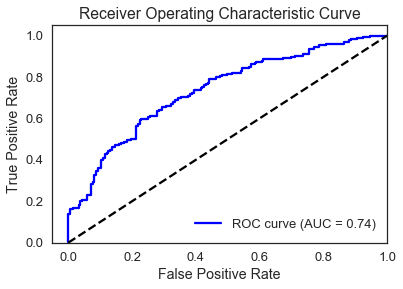

In [91]:
prefix = 'logistic_both_1015'
log_model = run_model.fit_model(x_train, y_train, model='logistic', save=False)
run_model.evaluate_model(x_train, y_train, log_model)
run_model.plot_roc_curve(log_model, x_train, y_train, save=False, prefix=prefix)

In [ ]:
run_model.plot_learning_curve(log_model, x_train, y_train, save=True, prefix=prefix)

In [35]:
coefs = np.around(log_model.coef_, 3)
coefs.reshape(-1)
std = x_vals.std(axis=0)
std_coef_series = pd.Series(np.reshape(np.array(std)*coefs, -1), index=std.index)
featimp_df = pd.DataFrame(data=[std, std_coef_series])
model_feature_importance = featimp_df.loc[1].abs().sort_values(ascending=False) #
model_feature_importance[:10]

Metronidazole              0.386707
Glycopeptide               0.265766
albumin                    0.248068
Fluoroquinolone            0.243800
bmi                        0.225062
weight                     0.221061
aniongap                   0.214059
admission_type_ELECTIVE    0.212629
sysbp_mean                 0.176048
bicarbonate                0.167046
Name: 1, dtype: float64

Use a Random Forest classifier with default settings (n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, warm_start=False, class_weight=None)

Accuracy: 0.6026272578
Classification report: 
             precision    recall  f1-score   support

          0       0.59      0.68      0.63       913
          1       0.62      0.52      0.57       914

avg / total       0.61      0.60      0.60      1827

Confusion matrix results: 
[[625 288]
 [438 476]]
False positives: 288
False negatives: 438


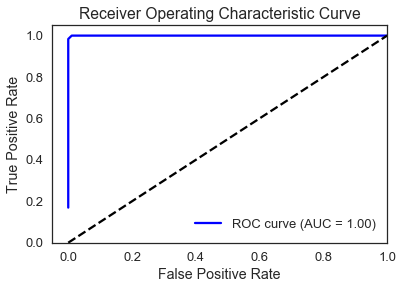

In [61]:
rf_model = RandomForestClassifier()
rf_model.fit(x_vals, y_train)

prefix = 'rf_default_both_1015'
run_model.evaluate_model(x_train, y_train, rf_model)
run_model.plot_roc_curve(rf_model, x_train, y_train, save=False, prefix=prefix)

# Use LogisticRegressionCV to optimize regularization

In [109]:
# now run model with score = roc_auc
logcv = LogisticRegressionCV(solver='saga', penalty='l2', scoring='roc_auc', 
                             max_iter=200, random_state=42)
logcv.fit(x_vals, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=200,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
           refit=True, scoring='roc_auc', solver='saga', tol=0.0001,
           verbose=0)

In [110]:
logcv.Cs_, logcv.scores_, logcv.n_iter_, logcv.C_

(array([  1.00e-04,   7.74e-04,   5.99e-03,   4.64e-02,   3.59e-01,
          2.78e+00,   2.15e+01,   1.67e+02,   1.29e+03,   1.00e+04]),
 {1: array([[ 0.69,  0.69,  0.69,  0.69,  0.69,  0.69,  0.69,  0.69,  0.69,
           0.69],
         [ 0.68,  0.69,  0.69,  0.69,  0.69,  0.69,  0.69,  0.69,  0.69,
           0.69],
         [ 0.7 ,  0.7 ,  0.71,  0.71,  0.71,  0.71,  0.71,  0.71,  0.71,
           0.71]])},
 array([[[ 13,  11,  24,  93, 200, 200, 200, 200, 200, 200],
         [ 15,  12,  26,  99, 200, 200, 188,  70,  14,   3],
         [ 14,  12,  26,  91, 150, 200, 200, 200, 200, 200]]], dtype=int32),
 array([ 0.01]))

In [111]:
logcv.coef_[0]

array([ 0.06, -0.21, -0.04,  0.04, -0.07,  0.1 ,  0.15, -0.03, -0.03,
       -0.12, -0.05,  0.04, -0.02,  0.06,  0.02,  0.1 ,  0.18,  0.  ,
       -0.03, -0.04,  0.1 ,  0.  , -0.04, -0.08,  0.09,  0.14,  0.02,
       -0.05, -0.08, -0.11,  0.11,  0.07, -0.09,  0.02,  0.04,  0.01,
        0.01,  0.1 , -0.08, -0.04, -0.03,  0.02,  0.06])

Accuracy: 0.64258347017
Classification report: 
             precision    recall  f1-score   support

          0       0.64      0.64      0.64       913
          1       0.64      0.65      0.64       914

avg / total       0.64      0.64      0.64      1827

Confusion matrix results: 
[[582 331]
 [322 592]]
False positives: 331
False negatives: 322


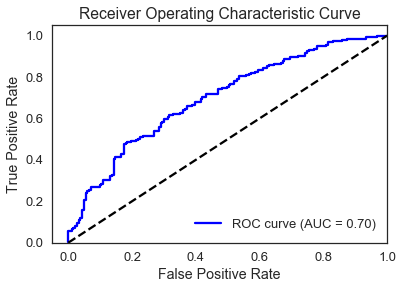

In [112]:
# evaluate model by CV
run_model.evaluate_model(x_train, y_train, logcv)
run_model.plot_roc_curve(logcv, x_train, y_train)

In [ ]:
run_model.plot_learning_curve(logcv, x_train, y_train)

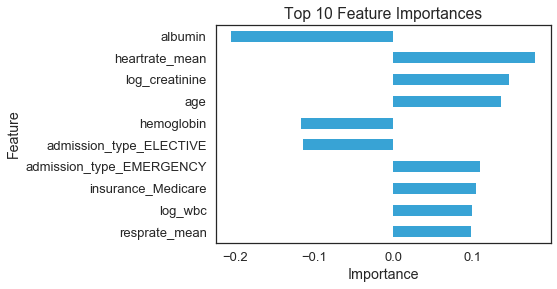

In [113]:
log_feature_imps = pd.DataFrame({'Feature': list(x_vals.columns), 
                             'Importance': logcv.coef_[0], 'Absolute': abs(logcv.coef_[0])})
log_feature_imps.sort_values(by='Absolute', ascending=False, inplace=True)
log_feature_imps.head(10)


plt.figure(figsize=(10, 20))
log_feature_imps[:10].plot(kind='barh', x='Feature', y='Importance', color='#38a3d5', legend=False)
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title("Top 10 Feature Importances")
#plt.savefig('/Users/nwespe/Desktop/logcv_both_feature_importances.svg', bbox_inches='tight')

In [114]:
log_feature_imps.head(10)

,Absolute,Feature,Importance
1,0.205630,albumin,-0.205630
16,0.179892,heartrate_mean,0.179892
6,0.146534,log_creatinine,0.146534
25,0.136406,age,0.136406
9,0.117471,hemoglobin,-0.117471
29,0.113988,admission_type_ELECTIVE,-0.113988
30,0.109412,admission_type_EMERGENCY,0.109412
37,0.104690,insurance_Medicare,0.104690
15,0.099867,log_wbc,0.099867
20,0.098683,resprate_mean,0.098683


In [ ]:
y_pred = logcv.predict(x_test)
class_names = ['No C diff', 'C diff']

# function copied from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('/Users/nwespe/Desktop/log_both_confusion_matrix.svg', bbox_inches='tight')

Accuracy: 0.64989059081
Classification report: 
             precision    recall  f1-score   support

          0       0.65      0.64      0.65       229
          1       0.65      0.66      0.65       228

avg / total       0.65      0.65      0.65       457



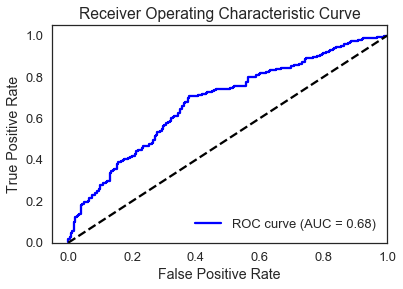

In [116]:
# evaluate model on test set
predictions = logcv.predict(x_test)
print 'Accuracy: ' + str(metrics.accuracy_score(y_test, predictions))
print 'Classification report: \n' + str(metrics.classification_report(y_test, predictions))
mat = metrics.confusion_matrix(y_test, predictions)

preds = logcv.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")

# Use GridSearchCV to optimize random forest

In [9]:
n_features = x_vals.shape[1]
clf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {"n_estimators": [250],  #50, 100, 500
              #'max_features': ['sqrt', 0.5],
              "max_depth": [4, 10, 20],
              "min_samples_leaf": [1, 3, 10]
             }

search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
search.fit(x_vals, y_train)
search.best_params_

{'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 250}

In [10]:
search_results = pd.DataFrame(search.cv_results_)
search_results.sort_values('rank_test_score')[:5]

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_samples_leaf,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
5,0.951965,0.116277,0.711143,0.941267,10,10,250,"{u'n_estimators': 250, u'max_depth': 10, u'min...",1,0.744483,...,0.667234,0.939258,0.736264,0.942116,0.712927,0.939638,0.008654,0.002955,0.028082,0.001693
1,0.874222,0.133561,0.709880,0.816626,4,3,250,"{u'n_estimators': 250, u'max_depth': 4, u'min_...",2,0.743289,...,0.667294,0.817025,0.725605,0.813209,0.717788,0.817813,0.017248,0.014418,0.026270,0.005296
8,0.976039,0.118771,0.709539,0.950250,20,10,250,"{u'n_estimators': 250, u'max_depth': 20, u'min...",3,0.742990,...,0.661949,0.948294,0.733652,0.951490,0.713863,0.948315,0.018376,0.006247,0.028951,0.001606
7,0.941234,0.122362,0.709228,0.999804,20,3,250,"{u'n_estimators': 250, u'max_depth': 20, u'min...",4,0.747798,...,0.665084,0.999631,0.738516,0.999749,0.705501,0.999826,0.013443,0.010680,0.030693,0.000107
2,0.849690,0.138058,0.709071,0.805243,4,10,250,"{u'n_estimators': 250, u'max_depth': 4, u'min_...",5,0.741318,...,0.666637,0.806892,0.725245,0.800973,0.716610,0.806757,0.024011,0.008645,0.025861,0.005623


Run and evaluate the optimized RF model

In [125]:
x_train.columns

Index([u'aniongap', u'albumin', u'log_bands', u'bicarbonate', u'log_bilirubin',
       u'log_bun', u'log_creatinine', u'chloride', u'log_glucose',
       u'hemoglobin', u'log_lactate', u'platelet', u'potassium', u'log_inr',
       u'sodium', u'log_wbc', u'heartrate_mean', u'sysbp_mean', u'diasbp_mean',
       u'meanbp_mean', u'resprate_mean', u'tempc_mean', u'spo2_mean_3',
       u'weight', u'bmi', u'age', u'rescaled_time', u'Aminoglycoside',
       u'Antifungal', u'Carbapenem', u'Cephalosporin', u'Combination',
       u'Fluoroquinolone', u'Glycopeptide', u'Lincosamide', u'Macrolide',
       u'Metronidazole', u'None', u'Other', u'Penicillin BS', u'Sulfonamide',
       u'gender', u'am_admit', u'admission_type_ELECTIVE',
       u'admission_type_EMERGENCY', u'admission_location_EMERGENCY ROOM ADMIT',
       u'admission_location_REFERRAL', u'admission_location_TRANSFER',
       u'ethnicity_WHITE', u'ethnicity_BLACK', u'insurance_Medicaid',
       u'insurance_Medicare', u'insurance_Private'

Accuracy: 0.63601532567
Classification report: 
             precision    recall  f1-score   support

          0       0.64      0.62      0.63       913
          1       0.63      0.65      0.64       914

avg / total       0.64      0.64      0.64      1827

Confusion matrix results: 
[[567 346]
 [319 595]]
False positives: 346
False negatives: 319


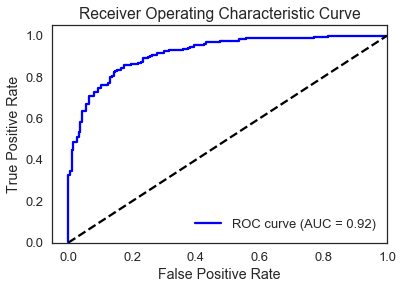

In [44]:
# evaluate model by CV
prefix = 'rf_opt_1016'
rf_opt = run_model.fit_model(x_train, y_train, model='rf', save=False, prefix=prefix)
run_model.evaluate_model(x_train, y_train, rf_opt)
run_model.plot_roc_curve(rf_opt, x_train, y_train, save=False, prefix=prefix)

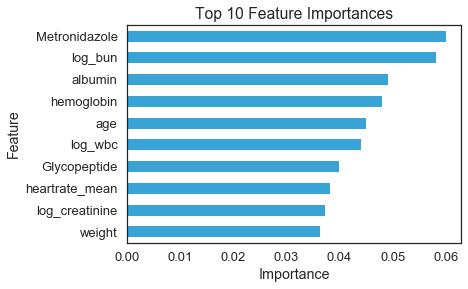

In [45]:
feature_imps = pd.DataFrame({'Feature': list(x_vals.columns), 
                             'Importance': rf_opt.feature_importances_,
                             'Std': np.std([tree.feature_importances_ for tree in rf_opt.estimators_], axis=0)})
feature_imps.sort_values(by='Importance', ascending=False, inplace=True)
feature_imps.head()

plt.figure(figsize=(10, 20))
feature_imps[:10].plot(kind='barh', x='Feature', y='Importance', color='#38a3d5', legend=False) # , xerr='Std'
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title("Top 10 Feature Importances")
#plt.savefig('/Users/nwespe/Desktop/rf_both_nostd_feature_importances.svg', bbox_inches='tight')

Accuracy: 0.689277899344
Classification report: 
             precision    recall  f1-score   support

          0       0.68      0.71      0.70       229
          1       0.70      0.67      0.68       228

avg / total       0.69      0.69      0.69       457



(0.0, 1.0)

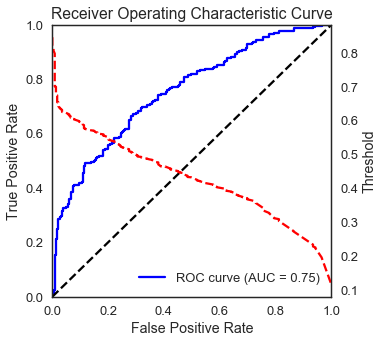

In [47]:
# evaluate model on test set
predictions = rf_opt.predict(x_test)
print 'Accuracy: ' + str(metrics.accuracy_score(y_test, predictions))
print 'Classification report: \n' + str(metrics.classification_report(y_test, predictions))
mat = metrics.confusion_matrix(y_test, predictions)

preds = rf_opt.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")

ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r', linestyle='dashed', color='r', label='Threshold')
ax2.set_ylabel('Threshold')
#ax2.set_ylim([thresholds[-1], thresholds[0]])
ax2.set_xlim([fpr[0], fpr[-1]])


#plt.savefig('/Users/nwespe/Desktop/rf_opt_test_thresh_roc_curve.svg', bbox_inches='tight')

Normalized confusion matrix
[[ 0.69  0.31]
 [ 0.33  0.67]]


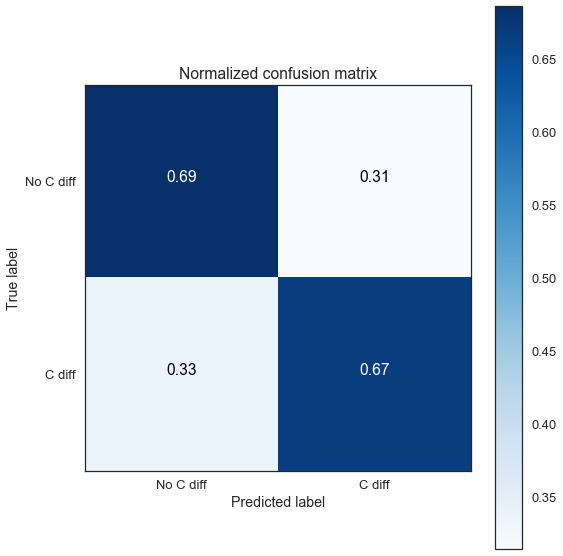

In [14]:
y_pred = rf_opt.predict(x_test)
class_names = ['No C diff', 'C diff']

# function copied from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('/Users/nwespe/Desktop/rf_both_confusion_matrix.svg', bbox_inches='tight')

In [15]:
feature_imps = pd.DataFrame({'name': list(x_vals.columns), 'importance': rf_opt.feature_importances_})
feature_imps.sort_values('importance', ascending=False)[:10]

,importance,name
5,0.057950,log_bun
36,0.055621,Metronidazole
1,0.047577,albumin
25,0.047312,age
9,0.046241,hemoglobin
15,0.042498,log_wbc
33,0.040647,Glycopeptide
16,0.037781,heartrate_mean
23,0.037007,weight
6,0.036093,log_creatinine


In [ ]:
cal_model = CalibratedClassifierCV(base_estimator=rf_opt, cv='prefit')

In [ ]:
# check probabilities and calibrate
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

x_test = test_set.drop(['outcome', 'hadm_id'], axis=1)
y_test = test_set['outcome'].copy().reset_index(drop=True)

y_pred = rf_opt.predict(x_test)
prob_pos = rf_opt.predict_proba(x_test)[:, 1]

cal_model = CalibratedClassifierCV(base_estimator=rf_opt, cv='prefit')
y_pred2 = cal_model.predict(x_test)
prob_pos2 = cal_model.predict_proba(x_test)[:, 1]

fig = plt.figure(1, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=11)
ax1.plot(mean_predicted_value, fraction_of_positives, "s-")

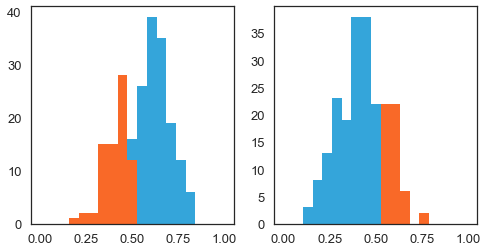

In [105]:
run_model.plot_probas(rf_opt, x_test, y_test)

In [ ]:
curr_model = rf_opt
X = x_test
y = y_test
probs = curr_model.predict_proba(X)
preds = curr_model.predict(X)
prob_df = pd.DataFrame(y)
prob_df['prob_0'] = probs[:,0]
prob_df['prob_1'] = probs[:,1]
prob_df['predict'] = preds
prob_df = prob_df.join([id_col, X])

true_pos = prob_df[(prob_df.outcome == 1) & (prob_df.predict == 1)]
true_neg = prob_df[(prob_df.outcome == 0) & (prob_df.predict == 0)]
false_pos = prob_df[(prob_df.outcome == 0) & (prob_df.predict == 1)]
false_neg = prob_df[(prob_df.outcome == 1) & (prob_df.predict == 0)]

bins = np.linspace(0, 1, 20)
fix, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(list(true_pos.prob_1.values), color='#34A5DA', alpha=1, bins=bins)
ax[0].hist(list(false_neg.prob_1.values), color='#F96928', alpha=1, bins=bins)
ax[1].hist(list(false_pos.prob_1.values), color='#F96928', alpha=1, bins=bins)
ax[1].hist(list(true_neg.prob_1.values), color='#34A5DA', alpha=1, bins=bins)

#plt.savefig('/Users/nwespe/Desktop/' + prefix + '_train_probas.svg', bbox_inches='tight')

# Now try XGBoost

In [ ]:
# test XGBoost with params from Random Forest
params = {'objective':'binary:logistic', 'n_estimators':500, 'max_depth': 10, 'seed': 42}
xgb_clf = xgb.XGBClassifier(**params)
xgb_clf.fit(x_vals, y_train)

prefix = 'xgb'
run_model.evaluate_model(x_train, y_train, xgb_clf)
run_model.plot_roc_curve(xgb_clf, x_train, y_train, save=True, prefix=prefix)

In [ ]:
# Optimize estimator number
xgdmat = xgb.DMatrix(x_train, y_train) # Create a DMatrix to make XGBoost more efficient
ind_params = {'eta': 0.06, 'seed': 42, 'objective': 'binary:logistic'}  # 'subsample': 0.8, 'colsample_bytree': 0.8, 'eta': 0.1,  

cv_xgb = xgb.cv(params = ind_params, dtrain = xgdmat, num_boost_round = 2000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

In [ ]:
cv_xgb.tail(5)

In [ ]:
ind_params = {'learning_rate': 0.06, 'seed': 42, 'objective': 'binary:logistic', 'n_estimators': 100}
cv_params = {'max_depth': [6],
             'min_child_weight': [1]
            }

xgb_opt = GridSearchCV(xgb.XGBClassifier(**ind_params), cv_params, scoring='recall', cv=5, n_jobs=-1) 
xgb_opt.fit(x_vals, y_train)

In [ ]:
xgb_opt.best_params_, xgb_opt.best_score_

In [ ]:
xgb_opt_results = pd.DataFrame(xgb_opt.cv_results_)
xgb_opt_results.sort_values('rank_test_score')[:5] #[(search_results['param_max_depth'] == 10) & (search_results['param_max_features'] == 'log2')]

In [ ]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 4} 
final_gb = xgb.train(our_params, xgdmat, num_boost_round = 48)

In [ ]:
xgb.plot_importance(final_gb)

In [ ]:
importances = final_gb.get_fscore()
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by='Importance', inplace=True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')

Check the best model on the test set

In [ ]:
curr_model = rf_opt

x_test = test_set.drop('outcome', axis=1)
y_test = test_set['outcome'].copy().reset_index(drop=True)

run_model.evaluate_model(x_test, y_test, curr_model)
run_model.plot_roc_curve(curr_model, x_test, y_test, save=True, prefix=prefix)

In [ ]:
risk, results = run_model.eval_risk(rf_opt)

In [ ]:
results['Probability'] = results['Probability'].apply(lambda x: "{{:{}%}}".format('0.1').format(x))

In [ ]:
risk, results

In [ ]:
ab_profile.iloc[:, 27:41]

In [ ]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(rf_opt, open(filename, 'wb'))

# Plot raw data

In [ ]:
bal_data = prepare_dataset.balance_dataset(cdiff_data, 'outcome')

In [ ]:
get_sql_dataset.plot_feature_counts(cdiff_data)

In [ ]:
get_sql_dataset.plot_probability_quantiles(cdiff_data, save=True)

In [ ]:
get_sql_dataset.plot_correlations(cdiff_data)

In [ ]:
get_sql_dataset.plot_features(cdiff_data, save=True)